#### Домашнее задание к лекции 5
1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, precision_score, roc_curve, auc
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

import xgboost as xgb
import seaborn as sns

#### Функции, для использования в заданиях

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def roc_auc_curve_draw(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)# C = 0.1
    roc_auc = auc(fpr, tpr)
    lw = 2

    plt.plot(fpr, 
             tpr, 
             lw=lw, 
             label="ROC curve (area = %0.2f)" % roc_auc)    
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    #plt.savefig("ROC.png")
    plt.show()
    return roc_auc

In [4]:
def precision_recall_draw(y_test, y_pred, precision, recall, n=-1):
    plt.plot(recall[:n],precision[:n] )
    plt.title(' точность/полнота')
    plt.xlabel(' полнота')
    plt.ylabel(' точность')
    plt.grid('On')
    plt.show()

In [5]:
# загружаем датасет:
df = pd.read_csv("churn_data.csv", index_col='RowNumber')
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [6]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
# Распределние классов
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [8]:
# Проверка датасета на NaN значения
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
#Обработчик данных в пайплайнах
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    """Implements get_dummies method for Categorial columns."""
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
#Создаем список категориальных и непрерывных переменных
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [11]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [12]:
y = df['Exited']
# предолагаем что 'CustomerId', 'Surname' не влияют на удовлетворенность сервисом
X = df.drop(['CustomerId', 'Surname', 'Exited'], axis = 1)

In [13]:
# Разбиваем датасет на train|test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
#Создаем пайплайн
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [15]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [16]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,class_weight={0:1,1:4} )),
])

In [17]:
#Проверка соотношения классов для последующего назначения весов
ratio = df['Exited'][df['Exited']== 1].value_counts()/df['Exited'].count()
ratio_1 = 1/ratio
ratio_0 = 1/(1 - ratio)

In [18]:
ratio_1[1]

4.909180166912126

In [19]:
ratio_0[1]

1.2558081125204068

In [20]:
#dataframe для хранения результатов
results_df = pd.DataFrame(columns = ['Model','threshold','Recall', 'Precision','F1 max', 'Auc'])
results_df

,Model,threshold,Recall,Precision,F1 max,Auc


#### Gradient Boosting

In [21]:
#пайплайн для градиентного бустинга
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators = 200, 
                                              random_state = 42,
                                              )),
])

In [22]:
#обучение модели
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [23]:
# предсказание
y_pred_gb = pipeline_gb.predict_proba(X_test)[:, 1]
y_pred_gb[:15]

array([0.04328034, 0.03343007, 0.09074145, 0.2287066 , 0.08568156,
       0.0141317 , 0.08341799, 0.23521929, 0.31349093, 0.32798988,
       0.98590178, 0.91968993, 0.63658542, 0.43149334, 0.01990963])

In [24]:
#Определение метрик для последующего анализа
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, y_pred_gb)

In [25]:
fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb)

In [26]:
#Определение индекса и связанных величин для высшего значения F1 метрики
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.276799, F-Score=0.639, Precision=0.597, Recall=0.688


Confusion matrix, without normalization
[[1772  231]
 [ 156  341]]


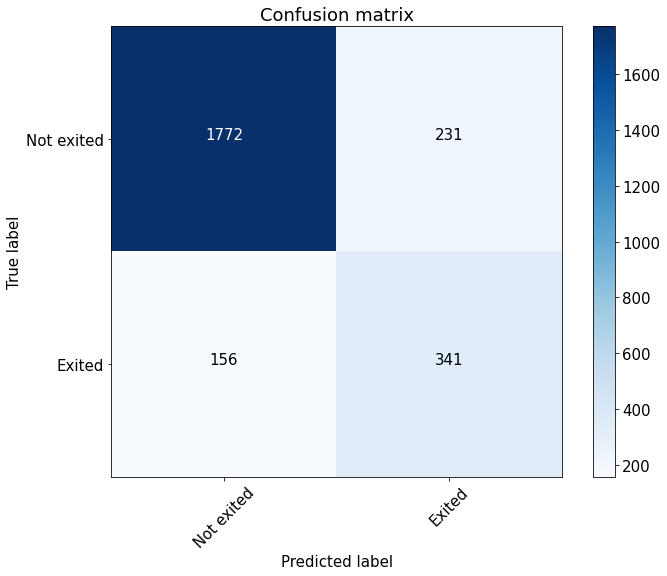

In [27]:
#Построение матрицы ошибок
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_pred_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

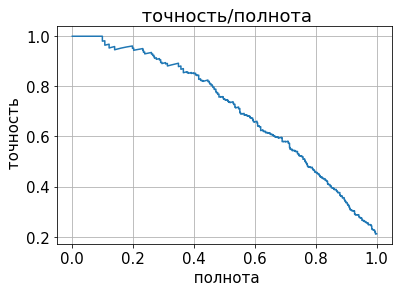

In [28]:
#Построение графика точность/полнота
precision_recall_draw(y_test, y_pred_gb, precision_gb, recall_gb)

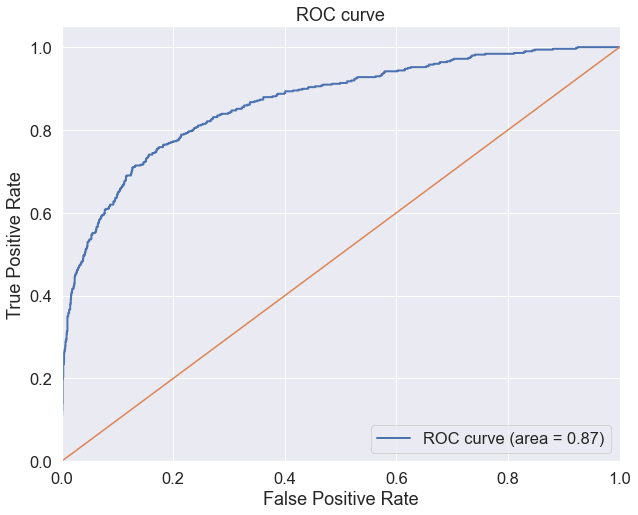

In [29]:
#ROC AUC
auc_gb = roc_auc_curve_draw(y_test, y_pred_gb)

In [30]:
#Сохраняем результаты
results_df = results_df.append({'Model':'Gradient Boosting', 
                   'threshold':thresholds_gb[ix_gb], 
                   'Recall': recall_gb[ix_gb], 
                   'Precision':precision_gb[ix_gb], 
                   'F1 max':fscore_gb[ix_gb],
                    'Auc' : auc_gb}
                  , ignore_index=True)

In [31]:
results_df

,Model,threshold,Recall,Precision,F1 max,Auc
0,Gradient Boosting,0.276799,0.688129,0.596859,0.639252,0.865799


#### Random Forest

In [32]:
#пайплайн для случайного леса
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,class_weight={0:ratio_0[1],1:ratio_1[1]} )),
])

In [33]:
#обучение модели
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [34]:
# предсказание
y_pred_rf = pipeline_rf.predict_proba(X_test)[:, 1]
y_pred_rf

array([0.01, 0.  , 0.17, ..., 0.06, 0.07, 0.1 ])

In [35]:
#Определение метрик для последующего анализа
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)

In [36]:
#Определение индекса и связанных величин для высшего значения F1 метрики
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.380000, F-Score=0.614, Precision=0.671, Recall=0.565


Confusion matrix, without normalization
[[1869  134]
 [ 220  277]]


C:\Users\effg\AppData\Local\Temp\ipykernel_8252\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


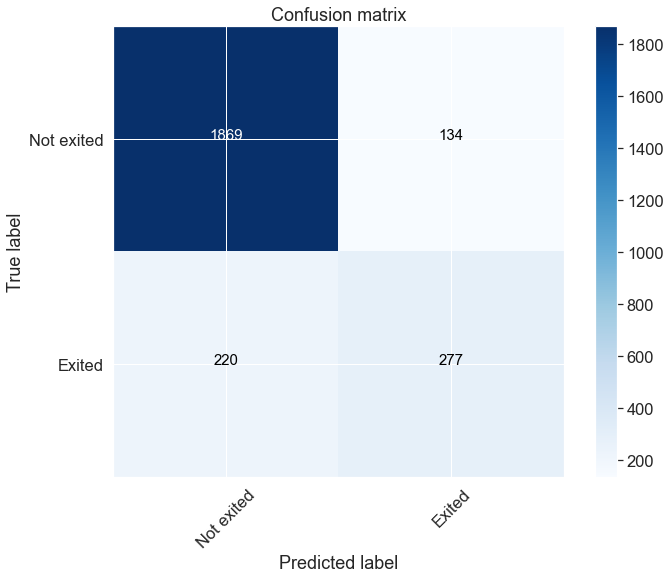

In [37]:
#Построение матрицы ошибок
font = {'size' : 15}

plt.rc('font', **font)
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")

plt.show()

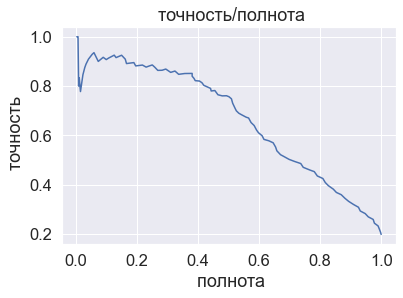

In [38]:
#Построение графика точность/полнота
precision_recall_draw(y_test, y_pred_rf, precision_rf, recall_rf)

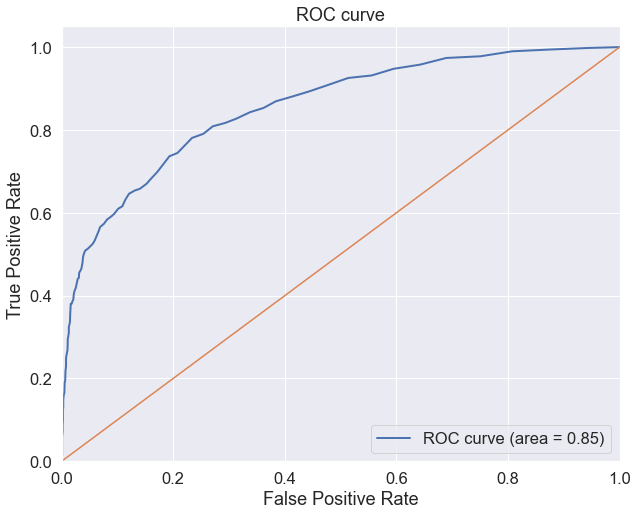

In [39]:
#ROC AUC
auc_rf = roc_auc_curve_draw(y_test, y_pred_rf)

In [40]:
#Сохраняем результаты
results_df = results_df.append({'Model':'Random Forest', 
                   'threshold':thresholds_rf[ix_rf], 
                   'Recall': recall_rf[ix_rf], 
                   'Precision':precision_rf[ix_rf], 
                   'F1 max':fscore_rf[ix_rf],
                    'Auc' : auc_rf}
                  , ignore_index=True)

In [41]:
results_df

,Model,threshold,Recall,Precision,F1 max,Auc
0,Gradient Boosting,0.276799,0.688129,0.596859,0.639252,0.865799
1,Random Forest,0.380000,0.565392,0.670644,0.613537,0.854415


#### Логистическая регрессия

In [42]:
#пайплайн для логистической регрессии
log_reg_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [43]:
#обучение модели
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [44]:
# предсказание
y_pred_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_pred_log_reg

array([0.24240617, 0.08200887, 0.31150697, ..., 0.03005728, 0.25532998,
       0.10224698])

In [45]:
#Определение метрик для последующего анализа
precision_log_reg, recall_log_reg, thresholds_log_reg = precision_recall_curve(y_test, y_pred_log_reg)
fscore_log_reg = (2 * precision_log_reg * recall_log_reg) / (precision_log_reg + recall_log_reg + 0.00000000000001)

In [46]:
#Определение индекса и связанных величин для высшего значения F1 метрики
ix_log_reg = np.argmax(fscore_log_reg)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_log_reg[ix_log_reg], 
                                                                        fscore_log_reg[ix_log_reg],
                                                                        precision_log_reg[ix_log_reg],
                                                                        recall_log_reg[ix_log_reg]))

Best Threshold=0.274065, F-Score=0.503, Precision=0.443, Recall=0.581


Confusion matrix, without normalization
[[1639  364]
 [ 209  288]]


C:\Users\effg\AppData\Local\Temp\ipykernel_8252\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


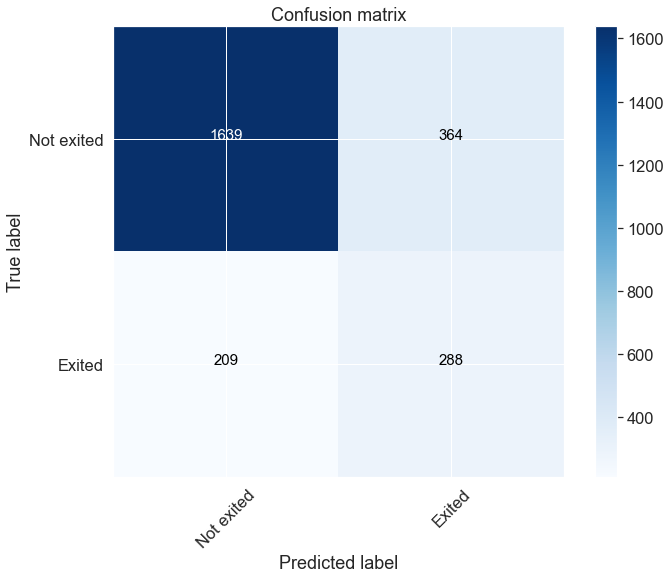

In [47]:
#Построение матрицы ошибок
font = {'size' : 15}

plt.rc('font', **font)
cnf_matrixlog_reg = confusion_matrix(y_test, y_pred_log_reg>thresholds_log_reg[ix_log_reg])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrixlog_reg, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")

plt.show()

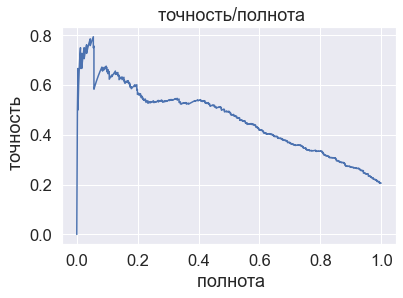

In [48]:
#Построение графика точность/полнота
precision_recall_draw(y_test, y_pred_log_reg, precision_log_reg, recall_log_reg)

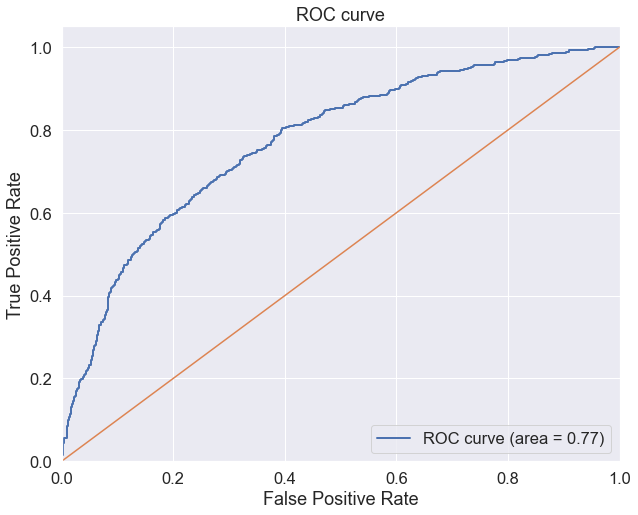

In [49]:
#ROC AUC
auc_log_reg = roc_auc_curve_draw(y_test, y_pred_log_reg)

In [50]:
#Сохраняем результаты
results_df = results_df.append({'Model':'Logistic Regression', 
                   'threshold':thresholds_log_reg[ix_log_reg], 
                   'Recall': recall_log_reg[ix_log_reg], 
                   'Precision':precision_log_reg[ix_log_reg], 
                   'F1 max':fscore_log_reg[ix_log_reg],
                    'Auc' : auc_log_reg}
                  , ignore_index=True)

In [51]:
results_df

,Model,threshold,Recall,Precision,F1 max,Auc
0,Gradient Boosting,0.276799,0.688129,0.596859,0.639252,0.865799
1,Random Forest,0.380000,0.565392,0.670644,0.613537,0.854415
2,Logistic Regression,0.274065,0.581489,0.442573,0.502609,0.773358


#### Вывод: лучшей моделью оказался градиентный бустинг с F-Score= 0.639252 , худшей - логистическая регрессия.

Оценка экономической эффективности при тех же вводных, как в вопросе 2 b
(1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного).

Confusion matrix, without normalization
[[1772  231]
 [ 156  341]]


C:\Users\effg\AppData\Local\Temp\ipykernel_8252\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


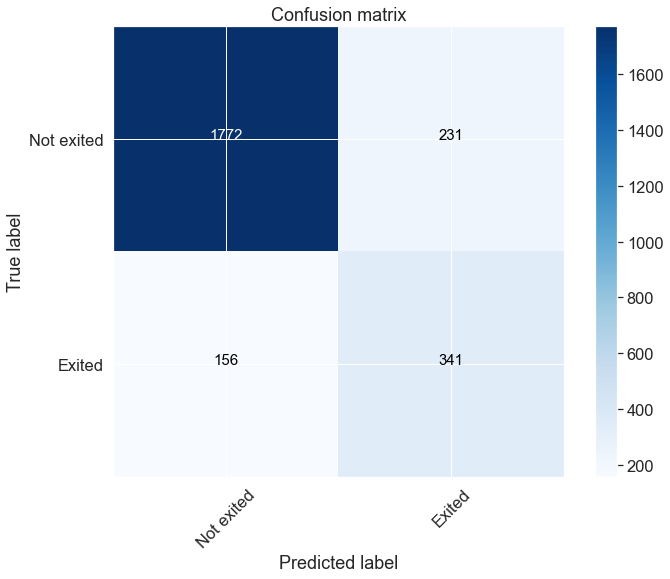

In [52]:
#Продублируем Confusion Matrix 
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_pred_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [53]:
#Расходы по деньгам, если все деньги пустить на удержание:
y_test.value_counts()

0    2003
1     497
Name: Exited, dtype: int64

In [54]:
y_test.shape[0]

2500

In [55]:
# Лучшие параметры с точки зрения модели
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.276799, F-Score=0.639, Precision=0.597, Recall=0.688


In [56]:
# Вывод параметров матрицы
tp = cnf_matrix_gb[0, 0]
fp = cnf_matrix_gb[1, 0]
fn = cnf_matrix_gb[0, 1]
tn = cnf_matrix_gb[1, 1]
print (tp, fp)
print (fn, tn)

1772 156
231 341


In [57]:
# Расчет экономических параметров с точки зрения оптимального порога по ML
money = 1
keep = 2

def business(money, keep, cnf_matrix):
    tp = cnf_matrix[0, 0]
    fp = cnf_matrix[1, 0]
    fn = cnf_matrix[0, 1]
    tn = cnf_matrix[1, 1]
    
    # доход в идеальном случае
    earnings_ideal = 2500 * money
    print(f"Доход в идеальном случае 100% сохранения клиентов {earnings_ideal}")
    
    #доход в случае отсутсвия затрат на удержание клиентов без затрат на привлечение новых
    earnings_free = (tp + fn)* money
    print(f"Доход в случае отсутсвия затрат на удержание клиентов без затрат на привлечение новых {earnings_free}")
    
    #доход в случае затрат на удержание FN + TN клиентов за вычетом утраты доходов от FP
    earnings_keep = money * (tp + fn) - keep*(fn + tn) - fp * money
    print(f"Доход в случае затрат на удержание клиентов за вычетом дохдов от незамеченных {earnings_keep}")

In [58]:
business(money, keep, cnf_matrix_gb)

Доход в идеальном случае 100% сохранения клиентов 2500
Доход в случае отсутсвия затрат на удержание клиентов без затрат на привлечение новых 2003
Доход в случае затрат на удержание клиентов за вычетом дохдов от незамеченных 703


#### Модель говорит что  экономического смысла удерживать клиентов - нет (что странно)